In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
from google.colab import drive
drive.mount('/content/drive' , force_remount = True)

Mounted at /content/drive


In [3]:
X_train = pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/train_data.csv' , index_col=None)
Y_train = pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/train_label.csv' , index_col=None)
X_test = pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/test_data.csv' , index_col=None)
Y_test= pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/test_label.csv' , index_col=None)

In [4]:
X_train_prep = X_train.copy()
Y_train_prep = Y_train.copy()
X_test_prep = X_test.copy()
Y_test_prep = Y_test.copy()

In [5]:
X_train_prep.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,dti,inq_last_6mths,revol_util,...,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified
0,36,16.24,C,0.0,OWN,19000.0,Verified,33.23,1.0,51.6,...,0,0,0,0,0,1,0,0,0,1
1,36,14.99,C,5.0,MORTGAGE,90000.0,Verified,21.43,1.0,97.2,...,0,0,1,0,0,0,0,0,0,1
2,36,7.90,A,10.0,MORTGAGE,56780.0,Not Verified,11.96,1.0,29.5,...,0,0,1,0,0,0,0,1,0,0
3,60,19.52,E,10.0,MORTGAGE,200000.0,Source Verified,9.97,0.0,82.4,...,0,0,1,0,0,0,0,0,1,0
4,36,14.33,C,3.0,MORTGAGE,65000.0,Source Verified,26.63,3.0,37.4,...,0,0,1,0,0,0,0,0,1,0


In [6]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326399 entries, 0 to 326398
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   term                                 326399 non-null  int64  
 1   int_rate                             326399 non-null  float64
 2   grade                                326399 non-null  object 
 3   emp_length                           326399 non-null  float64
 4   home_ownership                       326399 non-null  object 
 5   annual_inc                           326395 non-null  float64
 6   verification_status                  326399 non-null  object 
 7   dti                                  326399 non-null  float64
 8   inq_last_6mths                       326374 non-null  float64
 9   revol_util                           326164 non-null  float64
 10  total_acc                            326374 non-null  float64
 11  out_prncp    

#WoE Binning and Feature Engineering

$\text{Weight of Evidence (WoE) and Information Value (IV) are used for feature engineering and selection and are extensively used in the credit scoring domain.}$
$\text{WoE is a measure of the predictive power of an independent variable in relation to the target variable.}$ $\text{ It measures the extent a specific feature can differentiate between target classes.IV assists with ranking our features based on their relative importance.}$

$\text{WoE and IV for discrete features}$

$\text{WoE} = ln(\frac{\% \text{ of good customers}}{\% \text{ of bad customers}})$


$IV = \sum(\text{ of good consumer - % of bad consumer}) \times WoE$

##function for WoE for categorical feature

In [7]:
#Function for plotting
def woe_plot(df_woe , rotation=0) :
  """
  This function creates plot for woe values , given two input i.e. df_woe (woe data) and rotation for plot
  """
  sns.set()
  x = np.array(df_woe.iloc[:, 0].apply(str))
  y = df_woe['WoE']
  plt.figure(figsize=(12, 4))
  plt.plot(x, y, marker = 'o', linestyle = '-', color = 'b')
  plt.xlabel(df_woe.columns[0])
  plt.ylabel('Weight of Evidence')
  plt.title(str('Weight of Evidence by ' + df_woe.columns[0]))
  plt.xticks(rotation = rotation)

In [8]:

def woe_discrete(df , discrete_var , target_df ,rotation=0) :

  """
  This function takes 3 input namely dataframe (df) , discrete/categorical variable (discrete_var) and target values (target_df) 
  and returns dataframe ordered by woe and IV values of features 
  """
  
  df = pd.concat([df[discrete_var] , target_df] , axis=1) #creating dataframe with concating target values with feature values
  df = pd.concat([df.groupby(df.columns.values[0] , as_index=False)[df.columns.values[1]].count() , df.groupby(df.columns.values[0] , as_index=False)[df.columns.values[1]].mean()] , axis=1) 
  df = df.iloc[:,[0,1,3]] #giving names to column
  df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
  df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum() #proportion of observed = observed/sum(observed)
  df['n_good'] = df['prop_good'] * df['n_obs']  # value of good observations = prop of good * total observation
  df['n_bad'] = (1 - df['prop_good']) * df['n_obs'] #value of bad observations 
  df['prop_n_good'] = df['n_good'] / df['n_good'].sum() #proportion of good observations
  df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()  #proportion of bad observation
  df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad']) #WoE formula as above
  df = df.sort_values(['WoE']) #sorting values by WoE value
  df = df.reset_index(drop = True)
  df['diff_prop_good'] = df['prop_good'].diff().abs()
  df['diff_WoE'] = df['WoE'].diff().abs() #calculating diff of WoE
  df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE'] #formula of IV
  df['IV'] = df['IV'].sum()
  woe_plot(df , rotation)

  return df


In [9]:
display(X_train_prep.select_dtypes(include='object'))

,grade,home_ownership,verification_status
0,C,OWN,Verified
1,C,MORTGAGE,Verified
2,A,MORTGAGE,Not Verified
3,E,MORTGAGE,Source Verified
4,C,MORTGAGE,Source Verified
...,...,...,...
326394,B,RENT,Not Verified
326395,A,MORTGAGE,Not Verified
326396,C,MORTGAGE,Source Verified
326397,D,RENT,Source Verified


$\text{We have 3 discrete /categorcal variables .Lets find WoE for each feature.}$
$\text{Firstly for grade :}$

$\text{grade}$

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2309,0.722391,0.007074,1668.0,641.0,0.005737,0.017966,-1.141479,NaN,NaN,0.294813
1,F,9243,0.757005,0.028318,6997.0,2246.0,0.024068,0.062952,-0.961499,0.034615,0.179980,0.294813
2,E,24935,0.803208,0.076394,20028.0,4907.0,0.068891,0.137536,-0.691361,0.046203,0.270138,0.294813
3,D,53940,0.845755,0.165258,45620.0,8320.0,0.156920,0.233197,-0.396146,0.042546,0.295215,0.294813
4,C,87756,0.885740,0.268861,77729.0,10027.0,0.267366,0.281042,-0.049883,0.039985,0.346263,0.294813
5,B,95707,0.921437,0.293221,88188.0,7519.0,0.303342,0.210746,0.364208,0.035697,0.414091,0.294813
6,A,52509,0.961568,0.160874,50491.0,2018.0,0.173675,0.056561,1.121858,0.040131,0.757650,0.294813


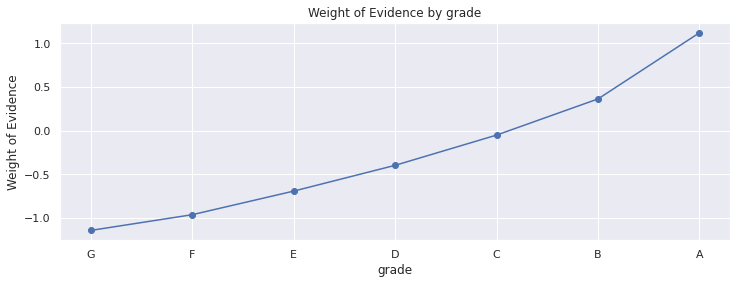

In [10]:
grade = woe_discrete(X_train_prep , 'grade' , Y_train_prep)
display(grade)


$\text{We can see from the above graph that there is a continuous increase in WoE across the different grades. Therefore, we do not need to combine any features together.}$

$\text{For Home ownership}$

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,136,0.779412,0.000417,106.0,30.0,0.000365,0.000841,-0.835588,NaN,NaN,0.021426
1,NONE,34,0.852941,0.000104,29.0,5.0,0.000100,0.000140,-0.339972,0.073529,0.495616,0.021426
2,RENT,131801,0.874090,0.403803,115206.0,16595.0,0.396277,0.465133,-0.160209,0.021149,0.179762,0.021426
3,OWN,29188,0.890983,0.089424,26006.0,3182.0,0.089453,0.089187,0.002988,0.016892,0.163197,0.021426
4,MORTGAGE,165240,0.903982,0.506252,149374.0,15866.0,0.513805,0.444700,0.144445,0.012999,0.141457,0.021426


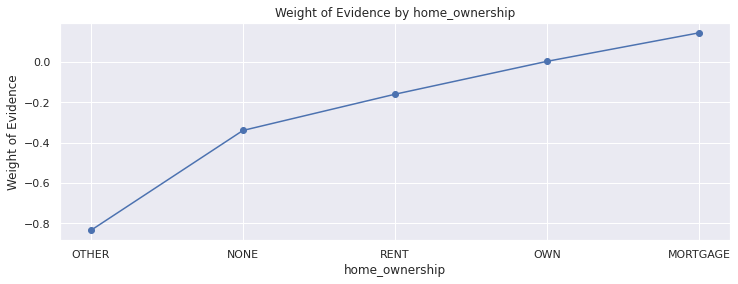

In [11]:
home= woe_discrete(X_train_prep , 'home_ownership' , Y_train_prep)
display(home)


$\text{For Verification status}$

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,117513,0.871844,0.360029,102453.0,15060.0,0.35241,0.422109,-0.180468,NaN,NaN,0.022863
1,Source Verified,105134,0.895828,0.322103,94182.0,10952.0,0.32396,0.306968,0.053877,0.023984,0.234345,0.022863
2,Not Verified,103752,0.906836,0.317869,94086.0,9666.0,0.32363,0.270923,0.177765,0.011007,0.123888,0.022863


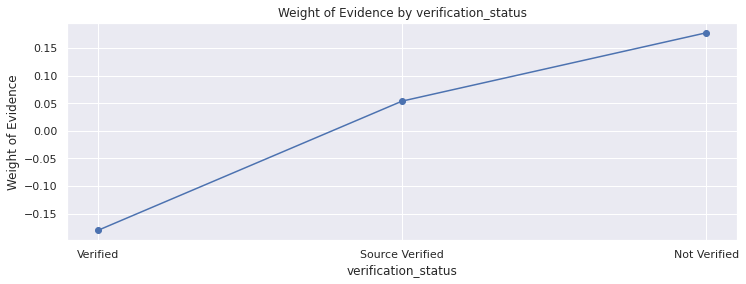

In [12]:
verification = woe_discrete(X_train_prep , 'verification_status' , Y_train_prep)
display(verification)

##function for WoE for numerical feature

In [13]:
def woe_continuous(df , conti_var , target_df) :

  """
  This function takes 3 input namely dataframe (df) , numerical variable (conti_var) and target values (target_df) 
  and returns dataframe ordered by woe and IV values of features 
  """
  
  df = pd.concat([df[conti_var] , target_df] , axis=1) #creating dataframe with concating target values with feature values
  df = pd.concat([df.groupby(df.columns.values[0] , as_index=False)[df.columns.values[1]].count() , df.groupby(df.columns.values[0] , as_index=False)[df.columns.values[1]].mean()] , axis=1) 
  df = df.iloc[:,[0,1,3]] #giving names to column
  df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
  df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum() #proportion of observed = observed/sum(observed)
  df['n_good'] = df['prop_good'] * df['n_obs']  # value of good observations = prop of good * total observation
  df['n_bad'] = (1 - df['prop_good']) * df['n_obs'] #value of bad observations 
  df['prop_n_good'] = df['n_good'] / df['n_good'].sum() #proportion of good observations
  df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()  #proportion of bad observation
  df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad']) #WoE formula as above
  df['diff_prop_good'] = df['prop_good'].diff().abs()
  df['diff_WoE'] = df['WoE'].diff().abs() #calculating diff of WoE
  df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE'] #formula of IV
  df['IV'] = df['IV'].sum()

  return df

In [14]:
display(X_train_prep.select_dtypes(include= 'number'))

,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,revol_util,total_acc,out_prncp,total_pymnt,...,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified
0,36,16.24,0.0,19000.0,33.23,1.0,51.6,23.0,0.00,2250.64000,...,0,0,0,0,0,1,0,0,0,1
1,36,14.99,5.0,90000.0,21.43,1.0,97.2,32.0,13992.07,14141.62000,...,0,0,1,0,0,0,0,0,0,1
2,36,7.90,10.0,56780.0,11.96,1.0,29.5,34.0,0.00,15288.77132,...,0,0,1,0,0,0,0,1,0,0
3,60,19.52,10.0,200000.0,9.97,0.0,82.4,48.0,27310.63,17441.43000,...,0,0,1,0,0,0,0,0,1,0
4,36,14.33,3.0,65000.0,26.63,3.0,37.4,56.0,2379.13,12351.44000,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326394,36,14.09,6.0,41800.0,22.85,2.0,83.7,12.0,0.00,12622.32274,...,0,0,0,0,0,0,1,1,0,0
326395,36,8.39,10.0,95000.0,10.80,0.0,77.8,26.0,9063.16,10778.70000,...,0,0,1,0,0,0,0,1,0,0
326396,36,14.65,9.0,65000.0,11.63,1.0,74.8,16.0,0.00,22692.16261,...,0,0,1,0,0,0,0,0,1,0
326397,60,15.58,2.0,30000.0,20.36,0.0,61.0,22.0,0.00,17698.79546,...,0,0,0,0,0,0,1,0,1,0


In [15]:
lst = X_train_prep.select_dtypes(include= 'number').columns

$\text{Calculating WoE for each feature}$

$\text{term}$

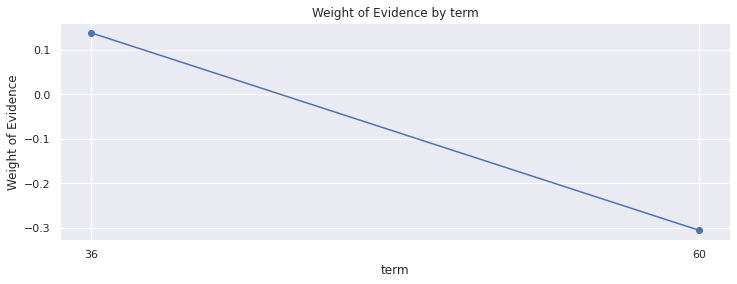

In [16]:
term = woe_continuous(X_train_prep , 'term' , Y_train_prep)
woe_plot(term)

int_rate

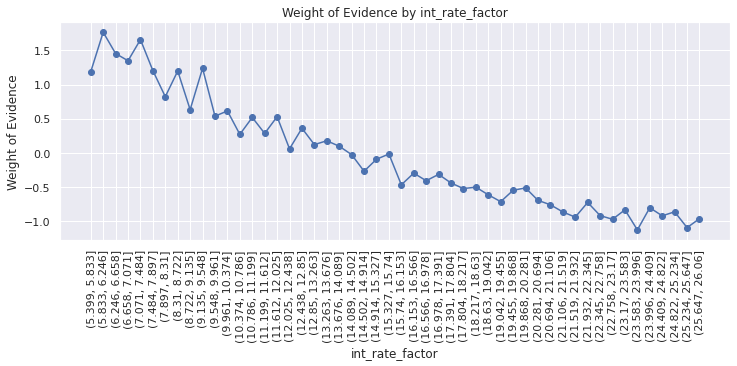

In [17]:
X_train_prep['int_rate_factor'] = pd.cut(X_train_prep['int_rate'] , 50) #Bin values into discrete intervals i.e. fine classing the discrete values as too many unique values
int_rate = woe_continuous(X_train_prep , 'int_rate_factor' , Y_train_prep)
woe_plot(int_rate ,90)

$\text{For the determining the bins in pd.cut method observe the data carefully.See Preprocessing file for more details}$

emp_length

In [18]:
df = woe_continuous(X_train_prep , 'emp_length' , Y_train_prep)


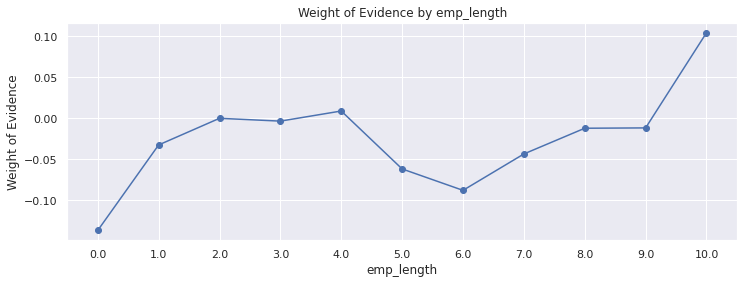

In [19]:
woe_plot(df)

$\text{This feature has very low IV value ,hence we will emit this features as its predictive power will be less.}$

In [20]:
# fine-classing
X_train_prep['annual_inc_factor'] = pd.cut(X_train_prep['annual_inc'], 50)
# Process 'annual_inc_factor' column through woe_ordered_continuous and plot_by_woe functions
df = woe_continuous(X_train_prep, 'annual_inc_factor', Y_train_prep)
import warnings
warnings.filterwarnings("ignore")

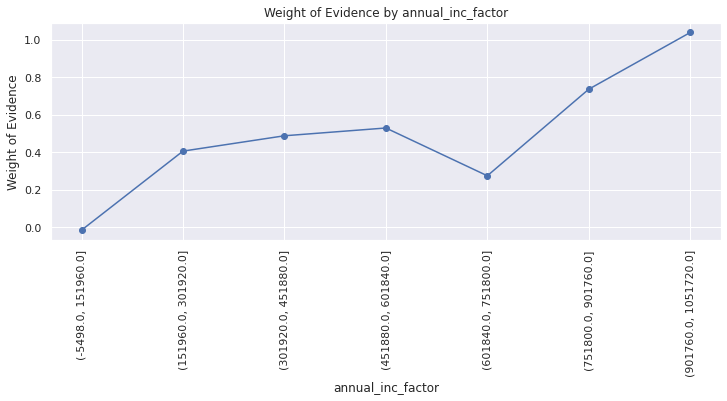

In [21]:
woe_plot(df,90)

In [22]:
X_train_tm = X_train_prep[X_train_prep['annual_inc'] <= 150000].copy()
X_train_tm['annual_inc_factor'] = pd.cut(X_train_tm['annual_inc'] , 50)
df = woe_continuous(X_train_tm , 'annual_inc_factor' , Y_train_prep)

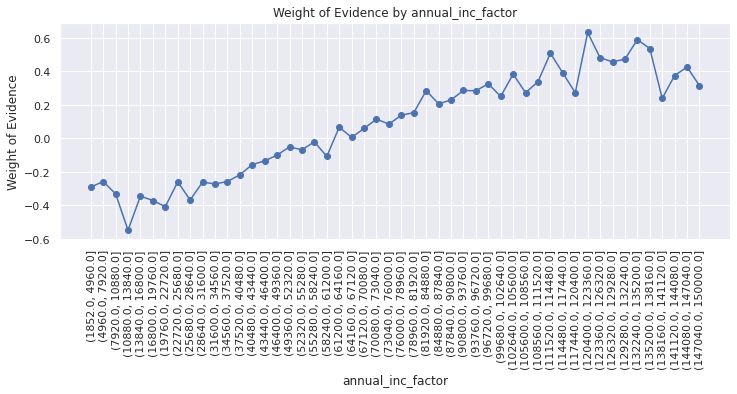

In [23]:

woe_plot(df ,90)

dti

In [24]:
X_train_prep['dti_factor'] = pd.cut(X_train_prep['dti'], 50)
df = woe_continuous(X_train_prep , 'dti_factor' , Y_train_prep)


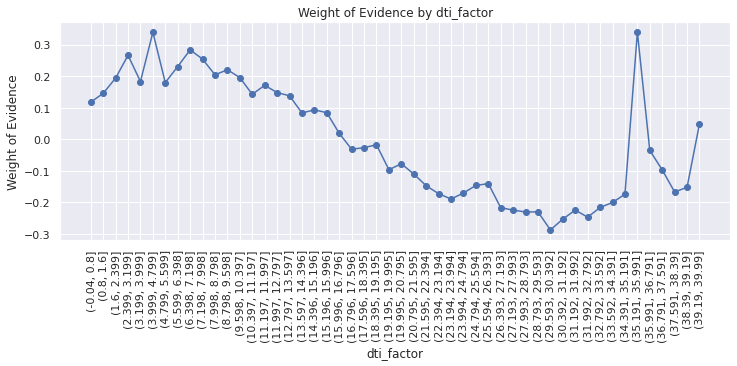

In [25]:
woe_plot(df,90)

inq_last_6months

In [26]:
df = woe_continuous(X_train_prep , 'inq_last_6mths' , Y_train_prep)
warnings.filterwarnings("ignore")


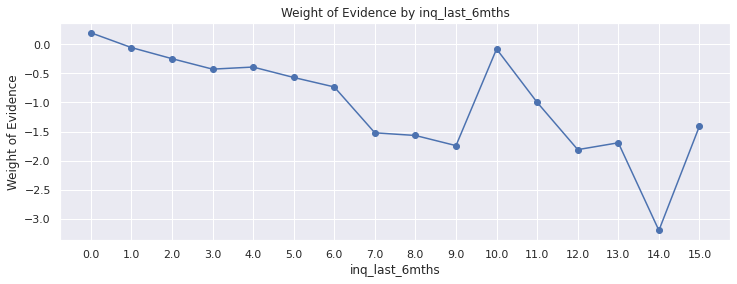

In [27]:
woe_plot(df)

revol_util

In [28]:
# Initial examination shows that there are some obs with utilization of >1 times which should be very rare, so we will filter them out first
X_train_prep_t = X_train_prep[X_train_prep['revol_util'] <= 1].copy()
# fine-classing
X_train_prep_t['revol_util_factor'] = pd.cut(X_train_prep_t['revol_util'], 10)
# preprocess 'revol_util'
df = woe_continuous(X_train_prep_t, 'revol_util_factor', Y_train_prep)


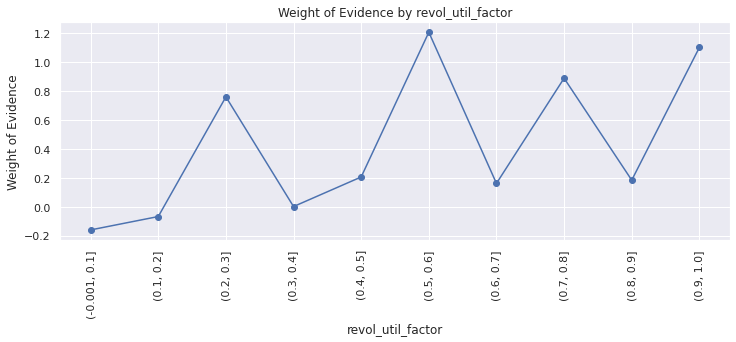

In [29]:
woe_plot(df , 90)

total_acc

In [30]:
X_train_prep_t = X_train_prep[X_train_prep['total_acc'] <= 50].copy()
X_train_prep_t["total_acc_factor"] = pd.cut(X_train_prep_t['total_acc'] , 20)
df = woe_continuous(X_train_prep_t , 'total_acc_factor' , Y_train_prep.iloc[X_train_prep_t.index])

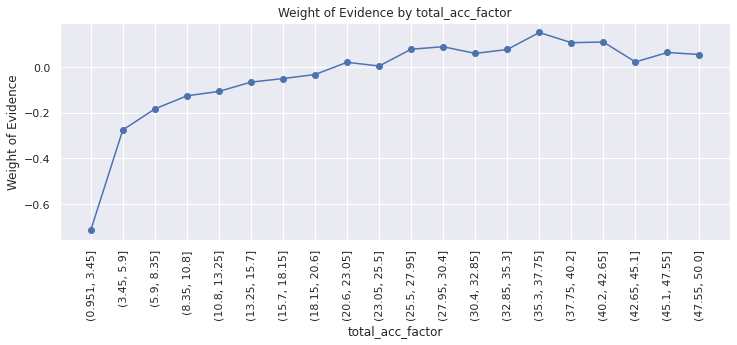

In [31]:
woe_plot(df,90)

$\text{All values are less than 0 , we can discard this feature}$

out_prncp

In [32]:
X_train_prep['out_prncp_factor'] = pd.cut(X_train_prep['out_prncp'] , 25)
df = woe_continuous(X_train_prep , 'out_prncp_factor' , Y_train_prep)


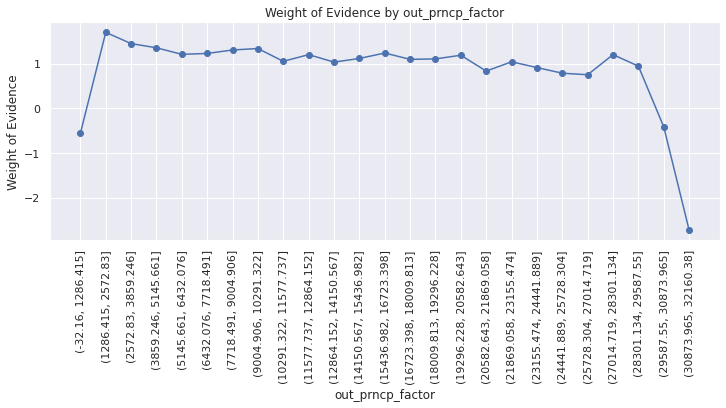

In [33]:
woe_plot(df,90)

toal_pymnt

In [34]:
temp = X_train_prep[X_train_prep['total_pymnt'] <= 25000].copy()
temp['total_pymnt_factor'] = pd.cut(temp['total_pymnt'], 20)
df = woe_continuous(temp , 'total_pymnt_factor' , Y_train_prep.iloc[temp.index])


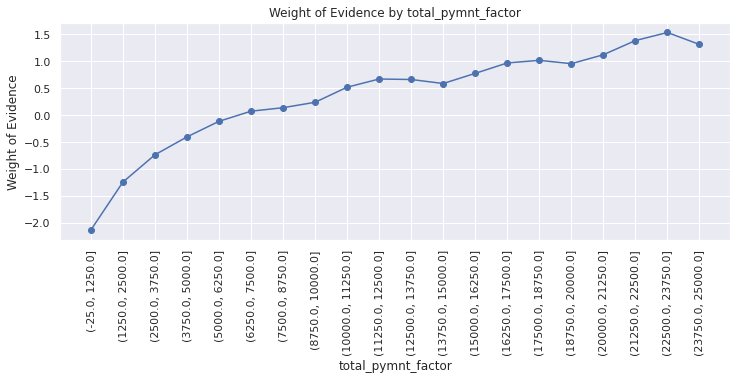

In [35]:
woe_plot(df, 90)

last_pymnt_amnt

In [36]:
temp = X_train_prep[X_train_prep['last_pymnt_amnt'] <= 10000].copy()
temp['last_pymnt_amnt_factor'] = pd.cut(temp['last_pymnt_amnt'], 15)
df = woe_continuous(temp , 'last_pymnt_amnt_factor' , Y_train_prep.iloc[temp.index])
df.head(10)

,last_pymnt_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-10.0, 666.667]",188235,0.844009,0.648103,158872.0,29363.0,0.623546,0.823600,-0.278263,NaN,NaN,1.045696
1,"(666.667, 1333.333]",41045,0.856962,0.141320,35174.0,5871.0,0.138052,0.164675,-0.176344,0.012953,0.101919,1.045696
2,"(1333.333, 2000.0]",5655,0.953846,0.019470,5394.0,261.0,0.021171,0.007321,1.061896,0.096884,1.238240,1.045696
3,"(2000.0, 2666.667]",5569,0.985096,0.019174,5486.0,83.0,0.021532,0.002328,2.224487,0.031250,1.162592,1.045696
4,"(2666.667, 3333.333]",5507,0.996187,0.018961,5486.0,21.0,0.021532,0.000589,3.598806,0.011091,1.374318,1.045696
5,"(3333.333, 4000.0]",5584,0.997493,0.019226,5570.0,14.0,0.021861,0.000393,4.019466,0.001306,0.420661,1.045696
6,"(4000.0, 4666.667]",5436,0.997976,0.018716,5425.0,11.0,0.021292,0.000309,4.234251,0.000484,0.214785,1.045696
7,"(4666.667, 5333.333]",5386,0.998700,0.018544,5379.0,7.0,0.021112,0.000196,4.677721,0.000724,0.443470,1.045696
8,"(5333.333, 6000.0]",4915,0.999390,0.016923,4912.0,3.0,0.019279,0.000084,5.434198,0.000689,0.756477,1.045696
9,"(6000.0, 6666.667]",4487,0.999554,0.015449,4485.0,2.0,0.017603,0.000056,5.748720,0.000165,0.314522,1.045696


$\text{The IV values are abnormally high hence we will ignore this feature.}$

total_rec_int

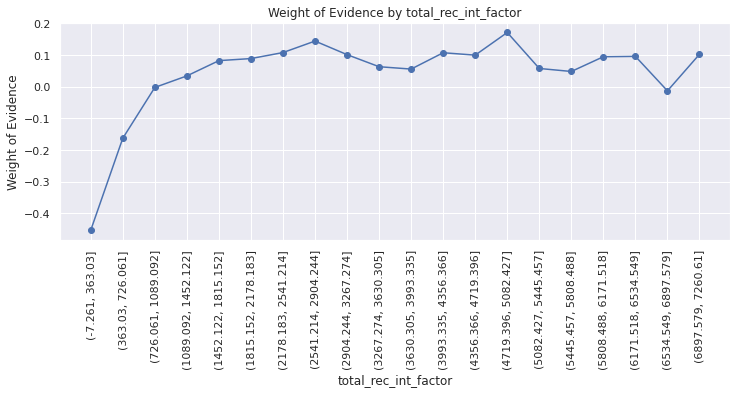

In [37]:
temp = X_train_prep[X_train_prep['total_rec_int'] <= 7261].copy()
temp['total_rec_int_factor'] = pd.cut(temp['total_rec_int'], 20)
df = woe_continuous(temp , 'total_rec_int_factor' , Y_train_prep.iloc[temp.index])
woe_plot(df,90)

tot_cur_bal

In [38]:
temp = X_train_prep[X_train_prep['tot_cur_bal'] <= 64000].copy()
temp['tot_cur_bal_factor'] = pd.cut(temp['tot_cur_bal'], 25)
df = woe_continuous(temp , 'tot_cur_bal_factor' , Y_train_prep.iloc[temp.index])
df.head(3)

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-64.0, 2560.0]",1533,0.901500,0.012205,1382.0,151.0,0.012426,0.010499,0.168571,NaN,NaN,0.003434
1,"(2560.0, 5120.0]",4019,0.899477,0.031998,3615.0,404.0,0.032504,0.028089,0.145996,0.002023,0.022575,0.003434
2,"(5120.0, 7680.0]",5618,0.897294,0.044729,5041.0,577.0,0.045326,0.040117,0.122081,0.002183,0.023915,0.003434


In [39]:
df['IV'].max()

0.0034344966362104125

$\text{We will ignore this feature due to low IV values}$

total_rev_hi_lim

In [40]:
temp = X_train_prep[X_train_prep['total_rev_hi_lim'] <= 79780].copy()
temp['total_rev_hi_lim_factor'] = pd.cut(temp['total_rev_hi_lim'], 25)
df = woe_continuous(temp , 'total_rev_hi_lim_factor' , Y_train_prep.iloc[temp.index])
df.head(10)

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-79.767, 3190.68]",3109,0.865230,0.011754,2690.0,419.0,0.011340,0.015348,-0.302612,NaN,NaN,0.021351
1,"(3190.68, 6381.36]",12777,0.881193,0.048305,11259.0,1518.0,0.047465,0.055604,-0.158264,0.015963,0.144349,0.021351
2,"(6381.36, 9572.04]",21532,0.884265,0.081405,19040.0,2492.0,0.080268,0.091282,-0.128582,0.003073,0.029682,0.021351
3,"(9572.04, 12762.72]",25278,0.885553,0.095567,22385.0,2893.0,0.094370,0.105971,-0.115941,0.001287,0.012641,0.021351
4,"(12762.72, 15953.4]",26097,0.888033,0.098664,23175.0,2922.0,0.097700,0.107033,-0.091232,0.002480,0.024709,0.021351
5,"(15953.4, 19144.08]",24548,0.890215,0.092807,21853.0,2695.0,0.092127,0.098718,-0.069098,0.002182,0.022134,0.021351
6,"(19144.08, 22334.76]",22054,0.893579,0.083378,19707.0,2347.0,0.083080,0.085971,-0.034202,0.003364,0.034896,0.021351
7,"(22334.76, 25525.44]",19414,0.894715,0.073397,17370.0,2044.0,0.073228,0.074872,-0.022202,0.001136,0.012000,0.021351
8,"(25525.44, 28716.12]",16865,0.898073,0.063761,15146.0,1719.0,0.063852,0.062967,0.013956,0.003358,0.036158,0.021351
9,"(28716.12, 31906.8]",14424,0.898988,0.054532,12967.0,1457.0,0.054666,0.053370,0.023990,0.000915,0.010034,0.021351


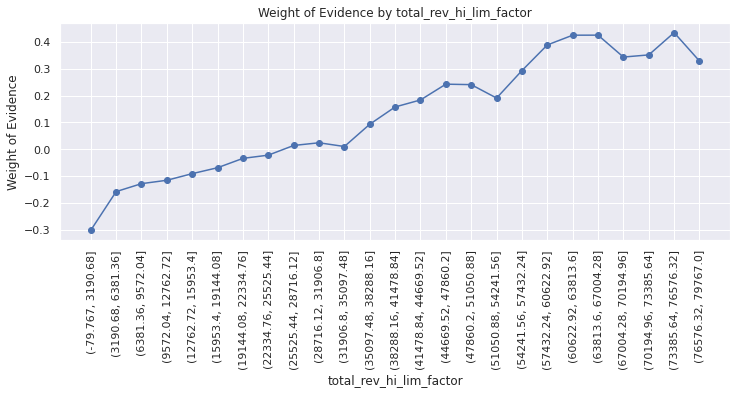

In [41]:
woe_plot(df,90)

months_since_earliest_cr_line

In [42]:
X_train_prep['months_since_earliest_cr_line_factor'] = pd.cut(X_train_prep['months_since_earliest_cr_line'], 25)
df = woe_continuous(X_train_prep, 'months_since_earliest_cr_line_factor', Y_train_prep)
df.head(10)

,months_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(128.486, 149.56]",2334,0.892888,0.007151,2084.0,250.0,0.007169,0.007008,0.022745,NaN,NaN,0.015578
1,"(149.56, 170.12]",5586,0.866094,0.017115,4838.0,748.0,0.016643,0.020967,-0.230984,0.026794,0.253730,0.015578
2,"(170.12, 190.68]",13728,0.861961,0.042062,11833.0,1895.0,0.040705,0.053118,-0.266165,0.004133,0.035180,0.015578
3,"(190.68, 211.24]",20540,0.874245,0.062934,17957.0,2583.0,0.061772,0.072404,-0.158810,0.012284,0.107355,0.015578
4,"(211.24, 231.8]",27085,0.884106,0.082988,23946.0,3139.0,0.082374,0.087989,-0.065941,0.009860,0.092869,0.015578
5,"(231.8, 252.36]",36207,0.885326,0.110937,32055.0,4152.0,0.110269,0.116384,-0.053975,0.001220,0.011966,0.015578
6,"(252.36, 272.92]",40189,0.884944,0.123138,35565.0,4624.0,0.122343,0.129615,-0.057736,0.000382,0.003761,0.015578
7,"(272.92, 293.48]",37545,0.888454,0.115037,33357.0,4188.0,0.114748,0.117393,-0.022794,0.003510,0.034942,0.015578
8,"(293.48, 314.04]",28964,0.891555,0.088745,25823.0,3141.0,0.088831,0.088045,0.008886,0.003101,0.031680,0.015578
9,"(314.04, 334.6]",25299,0.896399,0.077515,22678.0,2621.0,0.078012,0.073469,0.060001,0.004844,0.051115,0.015578


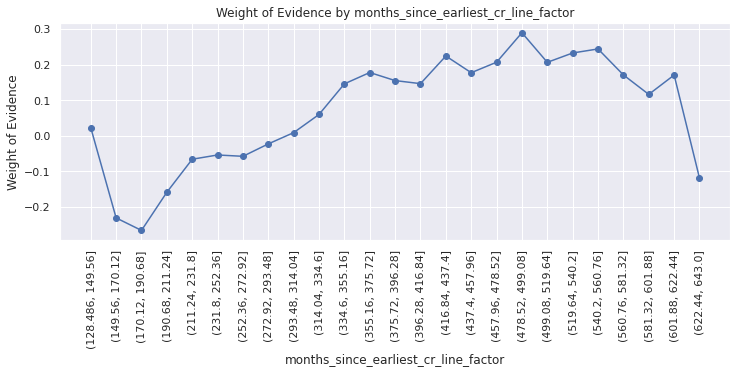

In [43]:
woe_plot(df,90)

months_since_issue_d

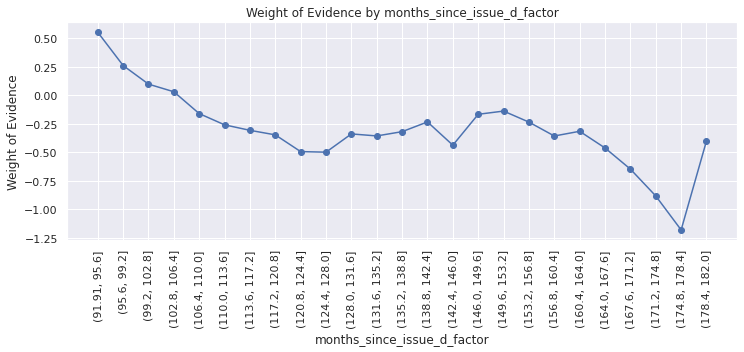

In [44]:
X_train_prep['months_since_issue_d_factor'] = pd.cut(X_train_prep['months_since_issue_d'], 25)
df = woe_continuous(X_train_prep, 'months_since_issue_d_factor', Y_train_prep)
woe_plot(df,90)

months_since_last_pymnt_d

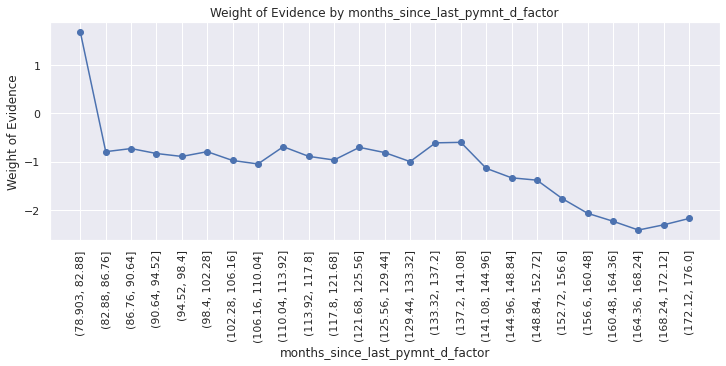

In [45]:
X_train_prep['months_since_last_pymnt_d_factor'] = pd.cut(X_train_prep['months_since_last_pymnt_d'], 25)
df = woe_continuous(X_train_prep, 'months_since_last_pymnt_d_factor', Y_train_prep)
woe_plot(df,90)

$\text{Ignoring this features due to high (more than 1)  IV values in intial range.}$

In [47]:
temp = X_train_prep[X_train_prep['months_since_last_credit_pull_d'] <= 80].copy()
temp['months_since_last_credit_pull_d_factor'] = pd.cut(temp['months_since_last_credit_pull_d'], bins=25)
df = woe_continuous(temp , 'months_since_last_credit_pull_d_factor' , Y_train_prep.iloc[temp.index])
df.head(10)

,months_since_last_credit_pull_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(78.999, 79.04]",229295,0.920478,0.958723,211061.0,18234.0,0.964793,0.893648,0.076601,NaN,NaN,0.084101
1,"(79.04, 79.08]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
2,"(79.08, 79.12]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
3,"(79.12, 79.16]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
4,"(79.16, 79.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
5,"(79.2, 79.24]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
6,"(79.24, 79.28]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
7,"(79.28, 79.32]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
8,"(79.32, 79.36]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101
9,"(79.36, 79.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084101


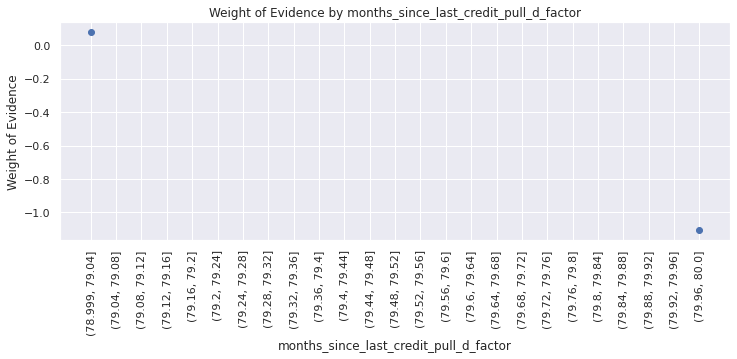

In [48]:
woe_plot(df,90)

#WoE & IV for test data

$\large \textbf{With this we have analysed WoE and IV value for all numerical as well as categorical features.}$
$\text{Now we will create a custom class from the values obtained in the above charts.So that we can apply our model on every dataset (like test)}$
$\text{without doing WoE and IV procedure manually again and again.}$

In [49]:
X_train.columns

Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'dti', 'inq_last_6mths',
       'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'months_since_issue_d', 'months_since_earliest_cr_line',
       'months_since_last_pymnt_d', 'months_since_last_credit_pull_d',
       'grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'grade:G', 'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'verification_status:Verified'],
      dtype='object')

In [50]:
#list of all the categories having one category from each of the global features that can be dropped from analysis as seen above(low or too high WoE/IV value)
categories = ['months_since_last_credit_pull_d:>75', 'months_since_issue_d:>122', 'months_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191','annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'verification_status:Not Verified', 'home_ownership:MORTGAGE', 'grade:G']

$\text{Special Thanks to @Asad_Mumtaz for the detailed information on WoE Binning via his blog (Can be found here)}$
[go to Asad's blog](https://https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03#:~:text=Weight%20of%20Evidence%20(WoE)%20and%20Information%20Value%20(IV),relation%20to%20the%20target%20variable)

$\text{The below code is the result of work of @Asad_Mumtaz which I have used for making the task easy :) and made some changes in variable names and few values best suited}$ $\text{for my data.Also we will make use of two modules from sklearn for creating dummy variables namely  BaseEstimator, TransformerMixin.}$

$\text{For details on sklearn modules click below :}$ 
1. [BaseEstimatort](https://https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
2. [TransformerMixIn](https://https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html?highlight=transformer#sklearn.base.TransformerMixin)

In [51]:
#This custom class will create new categorical dummy features based on the cut-off points that we manually identified based on the WoE plots and IV above.
#Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing us to use it as part of a scikit-learn Pipeline 

class WoE_Binning(BaseEstimator, TransformerMixin):
  def __init__(self, X): # no *args or *kargs
    self.X = X
  def fit(self, X, y = None):
    return self #nothing else to do
  def transform(self, X):
    X_new = X.loc[:, 'grade:A': 'grade:G']
    X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
    X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
    X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
    X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
    X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
    X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
    X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
    X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
    X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
    X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
    X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
    X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
    X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
    X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
    X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
    X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
    X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
    X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
    X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
    X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
    X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
    X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
    X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
    X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
    X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
    X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
    X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
    X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
    X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
    X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
    X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
    X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
    X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
    X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
    # We will discretize on the deciles for revol_util
    X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
    X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
    X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
    X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
    X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
    X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
    X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
    X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
    X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
    X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
    X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
    X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
    X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
    X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
    X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
    X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
    X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
    X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
    X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
    X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
    X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
    X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
    X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
    X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
    X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
    X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
    X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
    X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
    X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
    X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
    X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
    X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
    X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
    X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
    X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
    X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
    X_new['months_since_earliest_cr_line:missing'] = np.where(X['months_since_earliest_cr_line'].isnull(), 1, 0)
    X_new['months_since_earliest_cr_line:<125'] = np.where((X['months_since_earliest_cr_line'] <= 125), 1, 0)
    X_new['months_since_earliest_cr_line:125-167'] = np.where((X['months_since_earliest_cr_line'] > 125) & (X['months_since_earliest_cr_line'] <= 167), 1, 0)
    X_new['months_since_earliest_cr_line:167-249'] = np.where((X['months_since_earliest_cr_line'] > 167) & (X['months_since_earliest_cr_line'] <= 249), 1, 0)
    X_new['months_since_earliest_cr_line:249-331'] = np.where((X['months_since_earliest_cr_line'] > 249) & (X['months_since_earliest_cr_line'] <= 331), 1, 0)
    X_new['months_since_earliest_cr_line:331-434'] = np.where((X['months_since_earliest_cr_line'] > 331) & (X['months_since_earliest_cr_line'] <= 434), 1, 0)
    X_new['months_since_earliest_cr_line:>434'] = np.where((X['months_since_earliest_cr_line'] > 434), 1, 0)
    X_new['months_since_issue_d:<79'] = np.where((X['months_since_issue_d'] <= 79), 1, 0)
    X_new['months_since_issue_d:79-89'] = np.where((X['months_since_issue_d'] > 79) & (X['months_since_issue_d'] <= 89), 1, 0)
    X_new['months_since_issue_d:89-100'] = np.where((X['months_since_issue_d'] > 89) & (X['months_since_issue_d'] <= 100), 1, 0)
    X_new['months_since_issue_d:100-122'] = np.where((X['months_since_issue_d'] > 100) & (X['months_since_issue_d'] <= 122), 1, 0)
    X_new['months_since_issue_d:>122'] = np.where((X['months_since_issue_d'] > 122), 1, 0)
    X_new['months_since_last_credit_pull_d:missing'] = np.where(X['months_since_last_credit_pull_d'].isnull(), 1, 0)
    X_new['months_since_last_credit_pull_d:<56'] = np.where((X['months_since_last_credit_pull_d'] <= 56), 1, 0)
    X_new['months_since_last_credit_pull_d:56-61'] = np.where((X['months_since_last_credit_pull_d'] > 56) & (X['months_since_last_credit_pull_d'] <= 61), 1, 0)
    X_new['months_since_last_credit_pull_d:61-75'] = np.where((X['months_since_last_credit_pull_d'] > 61) & (X['months_since_last_credit_pull_d'] <= 75), 1, 0)
    X_new['months_since_last_credit_pull_d:>75'] = np.where((X['months_since_last_credit_pull_d'] > 75), 1, 0)
    X_new.drop(columns = categories, inplace = True)
    return X_new


In [52]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(326399, 36)
(326399, 1)
(139886, 36)
(139886, 1)
